# CM50268 :: Coursework 1 :: Bayesian Linear Regression

**Total Marks 15 (15% of overall unit marks).**

This coursework has 15 marks + 2 bonus marks, maximum mark is 15. 

*Submission deadline: 6pm, Friday February 28, 2021. Please submit this file in Moodle*

## Overview

Please ensure you carefully read all of the details and instructions on the assignment page, this section, and the rest of the notebook. If anything is unclear at any time please post on the forum or ask a tutor well in advance of the assignment deadline.

This coursework focuses on implementing some of the requisite calculations and manipulations for applying Bayesian linear regression models covered in Lectures 03 and 04.

Exercises include:

- computing the posterior distribution,
- computing the marginal likelihood,
- evaluating and choosing regularisation parameters,
- obtaining posterior mean models,
- calculating error-bars (the predictive variance), 
- ... some presentation of results.

The data will be derived from a synthetic, noisy, sine wave and our model will be a linearly-weighted set of "Gaussian" (RBF) basis functions. In a change from the lectures, a modification has been made to the data: there are no observations from one particular region of the data space. One of the aims of the lab is to see how this aspect impacts on the uncertainty of the model predictions.

There are 3 principal tasks (detailed below), with varying marks. In summary here:

1. Fit various Gaussian RBF-based linear models to the training data using penalised least-squares (OLS), and visualise the results (4 marks),
2. Replicate slide 17/21 of Lecture 04 using the model and data here  - that is, compute the train, validation and test set errors, plus the marginal likelihood (the red dashed curve in slide 17), over a range of $\lambda$ (or $\alpha$) values (9 marks + 1 bonus mark),
3. Identify the best posterior mean model, visualise it along with its error-bars (predictive variance), and consider how those error-bars might be usefully exploited (2 marks + 1 bonus mark).


## Submission & Marking

For this coursework there are a number of places where you are expected to enter your own code. Every place you have to add code is  indicated by:

`#### **** YOUR CODE HERE **** ####`


There is also one place where you are asked to enter explanatory text. Full instructions as to what is expected should be found above all the relevant cells.

**Please submit your completed workbook using Moodle**. The workbook you submit must be an `.ipynb` file, which is saved into the directory you're running Jupyter; alternatively you can download it from the menu above using `File -> Download As -> Notebook (.ipynb)`. Remember to save your work regularly (Save and Checkpoint in the File menu, the icon of a floppy disk, or Ctrl-S); the version you submit should have all code blocks showing the results (if any) of execution below them.

**You should take care to avoid any suggestion of plagiarism in your submission.** There is helpful information on how to avoid plagiarism on the University website: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

## Setup

### Support code

To get started, the code cell below imports the requisite standard Python modules, plus a setup module `cm50268_lab1_setup` specific to this lab. This module contains:

- the class `DataGenerator` to synthesise all the data sets needed,
- the class `RBFGenerator` to create the necessary Gaussian "RBF" basis matrices for varying data sets,
- the function `error_rms` to simply calculate errors for a given target values $t$ and corresponding model output $y$.

We also set some "constants" below: data set sizes and the generative noise standard deviation, which we fix at $\sigma=0.1$ for the entire exercise.


In [1]:
%matplotlib inline
# Standard modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# Lab-specific support module
import CM50268_CW1_Setup as lab1
#
N_train = 12
N_val   = N_train
N_test  = 250
#
sigma = 0.1
s2    = sigma**2


### Generate Data
We synthesise three data sets:
- training set of size $N_{train}=12$ with added noise $\sigma=0.1$
- validation set of size $N_{val}=12$ with added noise $\sigma=0.1$
- test set of size $N_{test}=250$ with **no noise** and **covers the full state space**

**Note:** we assume $\sigma$ is known and fixed. A feature of the test set is that *it will include data from a region where there is no training data*.

### Generate Basis
For our linear model, we use as many functions as data points (a "complete" basis), comprising $N-1$ equally-spaced Gaussian functions (of width 1), plus a fixed "bias" or "offset". If we call `evaluate` on the basis generator, we get a $N\times{}M$ matrix $\mathbf{\Phi}$ returned, where each column / row contains the output of each basis function on each data point respectively: that is, $\mathbf{\Phi}_{nm} = \phi_m(x_n)$. The use of a bias means the first column contains simply a fixed value of one. 

For the training and validation set, this matrix $\mathbf{\Phi}$ will be $12\times 12$, whereas for the test set it will be $250 \times 12$.

For illustration, the data and the underlying "ground-truth" (sine wave) are shown below, with basis functions overlaid.

<img src="data-and-basis.png" alt="Data and basis" style="width: 500px;"/>


In [2]:
# Data - create generator instance, and synthesise 3 sets
#
generator = lab1.DataGenerator(noise=sigma)
#
(x_train, y_train) = generator.get_data('TRAIN', N_train)
(x_val, y_val) = generator.get_data('VALIDATION', N_val)
(x_test, y_test) = generator.get_data('TEST', N_test)

# Basis - create generator instance and compute the basis matrices for all 3 data sets
# Note that because we use a "bias" function, we need N-1 Gaussians to make the
# basis "complete" (i.e. for M=N)
#
M = N_train-1
r = 1 # Basis radius or width
centres = np.linspace(generator.xmin, generator.xmax, M)
basis = lab1.RBFGenerator(centres, width=r, bias=True)
#
PHI_train = basis.evaluate(x_train)
PHI_val = basis.evaluate(x_val)
PHI_test = basis.evaluate(x_test)

## Task 1a 
**(2 marks)**

Write a function `fit_pls` (its signature is defined in the cell below) to fit a linear model with basis matrix `PHI_train` to the training data `y_train` for a given value of regularisation parameter $\lambda$. It should return the weight vector $\mathbf{w}_{PLS}$ that minimises the penalised least squares error.

You may find the functions `np.linalg.lstsq` and/or `np.linalg.inv` applicable.

The ideal solution will treat $\lambda=0$ case differently to $\lambda>0$.


In [3]:
## FIT_PLS
##
def fit_pls(PHI, y, lam):
    #
    #### **** YOUR CODE HERE **** ####
    #
    
    bracket = np.dot(np.transpose(PHI), PHI) +  np.dot(lam, np.eye(PHI.shape[0]))

    w = np.dot(np.dot(np.linalg.inv(bracket), np.transpose(PHI)), y)
    
    return w


## Task 1b
**(2 marks)**

1. Write `approxData_test` function, which uses the approximating function from `fit_pls` to compute the prediction, $y$, of test points `x_test`. 

2. Write a convenient graphing function `plot_regression` that you will need for this and following tasks. It should be capable of being passed suitable arguments to plot on the same axes:

    - the data (*i.e.* `y_train` above),
    - the generating function (*i.e.* the noise-free `y_test` above),
    - some approximating function, or prediction, $y$.

A simple example of output is shown below. 

<img src="regression.png" alt="Data and Predictor" style="width: 500px;"/>

Using `fit_pls` in conjunction with `plot_regression`, add code below to plot three graphs for values of $\lambda$ in \[ 0, 0.01, 10\]. In each graph (appropriately labelled by $\lambda$), show:

1. the training data (`x_train` / `y_train`)
2. the underlying generating function (by plotting `x_test` / `y_test`)
3. your fitted function at points `x_test` (you will need to multiply the relevant $\mathbf{\Phi}$ by $\mathbf{w}_{PLS}$)

You should find that the first $\lambda$ value over-fits, the second is "about right" (but only where there is data!) and the third under-fits.


			Plotting below graph where lambda is = 0


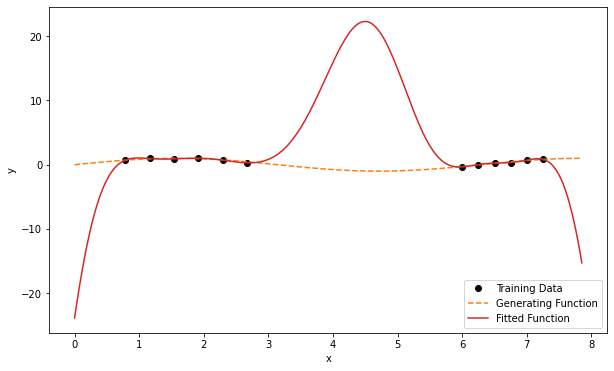

			Plotting below graph where lambda is = 0.01


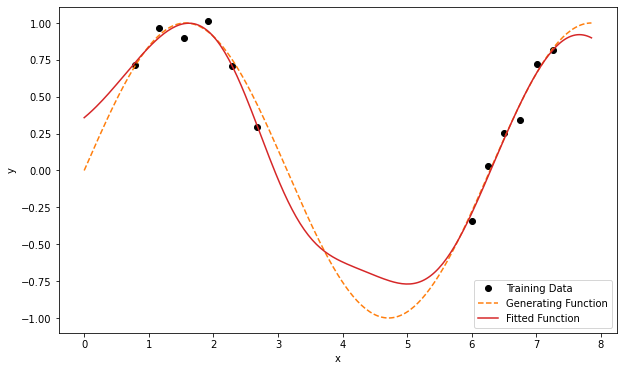

			Plotting below graph where lambda is = 10


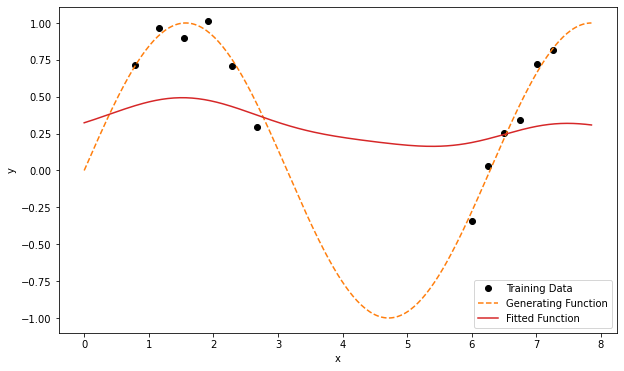

In [4]:
## PREDICTOR FOR TEST DATA
# 
def approxData_test(PHI_test,PHI_train, y_train,lam):
    #
    #### **** YOUR CODE HERE **** ####
    #
    # Multiplying relevant PHI by Wpls
    wpls = fit_pls(PHI_train, y_train, lam)
    prediction = np.dot(PHI_test, wpls)
    
    return prediction
    
## GRAPHING FUNCTION 
#  
def plot_regression(approxData_test, x_train, y_train, x_test, y_test):
    #
    #### **** YOUR CODE HERE **** ####
    #
    plt.figure(figsize=(10,6))
    
    plt.plot(x_train, y_train, 'o' , color='k', label='Training Data')
    plt.plot(x_test, y_test, '--', color='tab:orange', label='Generating Function')
    plt.plot(x_test, approxData_test, '-', color='tab:red', label='Fitted Function')

    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.legend(loc='lower right')

# Add code to plot for lam=0,lam=0.01 and lam=10 case
#
#### **** YOUR CODE HERE **** ####
#
lams = [0, 0.01, 10]
for lam in lams:
    
    predictions = approxData_test(PHI_test, PHI_train, y_train, lam)
    
    print('\t\t\tPlotting below graph where lambda is =', lam)
    plot_regression(predictions, x_train, y_train, x_test, y_test)
    plt.show()


## Task 2a
**(2 marks)**

Write a function `compute_posterior` to compute the posterior mean $\mathbf{\mu}$ and covariance $\mathbf{\Sigma}$ for the Bayesian linear regression model with basis matrix $\mathbf{\Phi}$ and with hyperparameters $\alpha$ and $\sigma^2$, where $\alpha = \lambda/\sigma^2$ for the equivalence.

Verify the consistency of your posterior code with `fit_pls` by comparing the outputs `w` and `Mu` (they should be the same). As well as defining your function below, append a few lines of code underneath which show your consistency check for $\lambda=0.01$.


In [5]:
## POSTERIOR
##
def compute_posterior(PHI, y, alph, s2):
    #
    #### **** YOUR CODE HERE **** ####
    #
    lam = alph * s2
    Mu = fit_pls(PHI_train, y, lam)
    
    PHI_transpose = np.transpose(PHI)
    SIGMA = np.dot(s2, np.linalg.inv(np.dot(PHI_transpose, PHI) +  np.dot(lam, np.eye(PHI.shape[0]))))
    
    return Mu, SIGMA

# check consistency
#### **** YOUR CODE HERE **** ####
lambd = 0.01
alph = lambd/s2
Mu, SIGMA = compute_posterior(PHI_train, y_train, alph, s2)

w = fit_pls(PHI_train, y_train, lambd)

# Check whether your variables are defined as the requirement  ..
try:
    Mu 
    w
except Exception as err:
    print('Error during checking consistency:', err)

## Task 2b
**(2 marks + 1 bonus mark)**

Write a function `compute_log_marginal` to compute the *logarithm* of the marginal likelihood for the Bayesian linear regression model with basis matrix $\mathbf{\Phi}$ and with hyperparameters $\alpha$ and $\sigma^2$.

In Lecture 04, we have illustrated the equations of finding the most probable hyperparameters to maximise the likelihood with respect to the hyperparameters. The likelihood of the hyperparameters can also be treated as the evidence with respect to $\mathbf{w}$. 

In our lab 1 example, the integral form of evidence computation can be rewritten as follows:

$p(\mathbf{y}|\alpha, \sigma^2) = (2 \pi)^{-\frac{N}{2}} |\sigma^2 \mathbf{I} + \alpha^{-1} \mathbf{\Phi}\mathbf{\Phi}^{\top}|^{-\frac{1}{2}} \exp\{ -\frac{1}{2} \mathbf{y}^{\top} (\sigma^2 \mathbf{I} + \alpha^{-1} \mathbf{\Phi}\mathbf{\Phi}^{\top})^{-1} \mathbf{y}  \}$

In principle, please use `stats.multivariate_normal.logpdf` for log density computation (don't compute the pdf and then call `np.log`!).

In practice, you should not have numerical issues using `stats.multivariate_normal.logpdf` (this can happen if you experiment with larger data sets, in which case you may wish to look at the `allow_singular` argument.)

**Bonus**: there is an alternative, and more robust, way of calculating the marginal likelihood directly, which you may wish to explore if you are comfortable with linear algebra and matrix identities. (**1 bonus mark**)


In [6]:
## MARGINAL LIKELIHOOD
##
def compute_log_marginal(PHI, y, alph, s2):
    #
    #### **** YOUR CODE HERE **** ####
    #
    # Using the part covariance of the PDF of the multivariate normal distribution
    S = (s2*np.eye(PHI.shape[0]) + (alph**-1)*np.dot(PHI, np.transpose(PHI)))

    lgp = stats.multivariate_normal.logpdf(x=np.squeeze(y), cov=S)
    
    return lgp


# Task 2c
**(3 marks)**

In the cell below, write some code to replicate below figure (shown in Lecture 04) for the Gaussian RBF basis and the `y_train` data defined above. 

<img src="slide15.png" alt="Slide 15 from Lecture 4" style="width: 400px;"/>

In more detail, over a range of $\lambda$ (or equivalent $\alpha=\lambda/\sigma^2$) values, you should:

- Compute the train, validation and test set errors（`err_train`,`err_val`,`err_test`）for the penalised least-squares model (use your `fit_pls` to fit it, and the supplied `error_rms` in 'CM50268_CW1_Setup'to calculate the error). 
- Also compute the *negative* log marginal likelihood (`neglog_evidence`), using the function just written.
- Plot **all these curves on the same graph**, noting that the scale for the errors is different for that of the negative log marginal likelihood.
- In addition to plotting the graph below, add code to compute, and output (using `print`), the *test error* corresponding to the minimum point on: (1) the test error curve itself, (2) the validation curve, (3) the negative marginal likelihood curve.

For easiest interpretation and automarking, please define your $\lambda$ range logarithmically and **fix the range between $-13$ and $5$**. 

First use `np.linspace(begin,end,steps)` to create equally spaced values `v`, then specify `lambda = 10**v`. Please **fix the `steps` value as 100**.

You should find that your graph has a similar qualitative form to the above figure, although the test error curve looks rather "sharp".

**Hints:** 
- You can create a new $y$-axis on the same plot, which shares the $x$-axis, using `plt.gca().twinx()`.
- Remember that $\alpha=\lambda/\sigma^2$. If you don't rescale appropriately, the marginal likelihood curve will not be correctly aligned with the error curves and your minimum point will be incorrect.




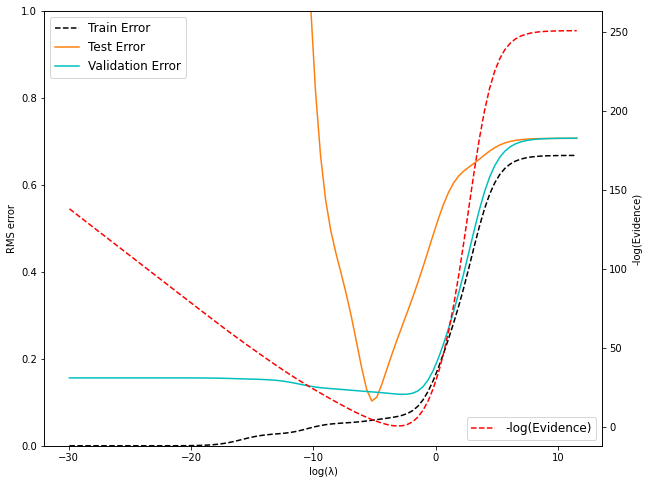

In [7]:
#
#### **** YOUR CODE HERE **** ####
#
#Set up plotting spaces
v = np.linspace(-13, 5, 100)
lambdas = 10**v

#Calculate the error in the train, test and validation sets and 
# the negative log marginal likelihood for a range of lambda
err_train = []
err_test = []
err_val = []
neglog_evidence = []

for lambd in lambdas:
    
    w_pls = fit_pls(PHI_train, y_train, lambd)
    
    train_pred = np.dot(PHI_train, w_pls)
    train_error = lab1.error_rms(train_pred, y_train)
    err_train.append(train_error)

    test_pred = np.dot(PHI_test, w_pls)
    test_error = lab1.error_rms(test_pred, y_test)
    err_test.append(test_error)

    val_pred = np.dot(PHI_val, w_pls)
    val_error = lab1.error_rms(val_pred, y_val)
    err_val.append(val_error)
    
    # Calculating negative log marginal
    alpha = lambd/s2
    neglog_evidence.append(-compute_log_marginal(PHI_train, y_train, alpha, s2))

## PLOT ALL THE CURVES ON THE SAME GRAPH
plt.figure(figsize=(10,8))

plt.plot(np.log(lambdas), err_train, '--', color='k', label='Train Error')
plt.plot(np.log(lambdas), err_test, '-', color='tab:orange', label='Test Error')
plt.plot(np.log(lambdas), err_val, '-', color='c', label='Validation Error')

plt.xlabel("log(λ)")
plt.ylabel("RMS error")
plt.legend(loc='upper left',  prop={'size': 12})
plt.ylim([0,1])

plt.gca().twinx()
plt.plot(np.log(lambdas), neglog_evidence, '--', color='r', label='-log(Evidence)')
plt.ylabel('-log(Evidence)')
plt.legend(loc='lower right',  prop={'size': 12})
plt.show()

# Check whether your variables are defined as the requirement  ..
try:
    err_train
    err_val
    err_test
    neglog_evidence
except Exception as err:
    print('Error during Calculating the error and negative log marginal likelihood:', err)

In [8]:
## PRINT THE TEST ERROR
# Print the test error corresponding to the minimum point on (1) the test error curve itself,
# (2) the validation curve, (3) the negative marginal likelihood curve
#
#### **** YOUR CODE HERE **** ####
#
min_test_error_index = err_test.index(min(err_test))
print('(1) Test error (on minimum test error point):', err_test[min_test_error_index])
print('(2) Validation error (on minimum test error point):', err_val[min_test_error_index])
print('(3) Negative marginal likelihood error error (on minimum test error point):', neglog_evidence[min_test_error_index])

(1) Test error (on minimum test error point): 0.10294116860772887
(2) Validation error (on minimum test error point): 0.12400676480926895
(3) Negative marginal likelihood error error (on minimum test error point): 4.493683273540642


# Task 2d
**(2 marks)**

Find the best value of $\alpha$ according to the marginal likelihood in Task 2c above, call `compute_posterior` to find the posterior mean weight vector `Mu` and use this to compute the posterior mean predictor `y_post`  (*i.e.* $y=\Phi\mu$) at all the test points `x_test`. Then, similar to Task 1b, using your earlier `plot_regression` function, plot on the same axes:
1. the training data (`x_train` / `y_train`),
2. the underlying generating function (by plotting `x_test` and `y_test`),
3. the posterior mean predictor function you just calculated.

You should find that the predictor is a pretty good fit to the underlying generating function *where there was data in the training set*. We can't expect the model to make good predictions in the "gap" where it has not seen any training data (unless it gets lucky!).


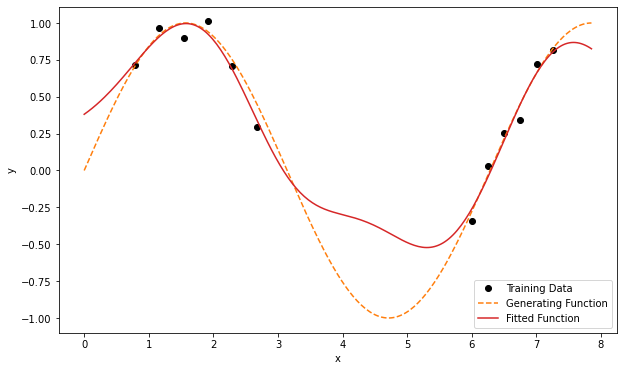

In [9]:
# add code to calculate posterior mean predictor and plot
#### **** YOUR CODE HERE **** ####
best_marglike_index = neglog_evidence.index(min(neglog_evidence))
best_lambd = lambdas[best_marglike_index]
best_alpha = best_lambd/s2

Mu, SIGMA = compute_posterior(PHI_train, y_train, best_alpha, s2)
y_post = np.dot(PHI_test, Mu)

plot_regression(y_post, x_train, y_train, x_test, y_test)
plt.show()

# Check whether your variables are defined as the requirement  ..
try:
    y_post
except Exception as err:
    print('Error during calculating posterior :', err)

# Task 3a
**(2 mark)**

Repeat the graph above (Task 2d), for the same "best" predictor, but this time also compute the predictive variance matrix `var_matrix` at the points `x_test` and add them to the same plot as "error bars". For plotting the "error bars", you need to calculate the upper and lower bound for the predicted value ( `upper_bound`,`lower_bound`). 

**Notes:**

- By "error bars" we mean the predictive standard deviation, please fix the error bars by +/- one standard deviation,
- To compute the predictive variance at `x_test`, you'll need the matrix `PHI_test`,
- The matplotlib function `plt.fill_between` is a handy utility for plotting error bars,
- If your calculations are correct, you should expect to see larger error bars where there is no data.

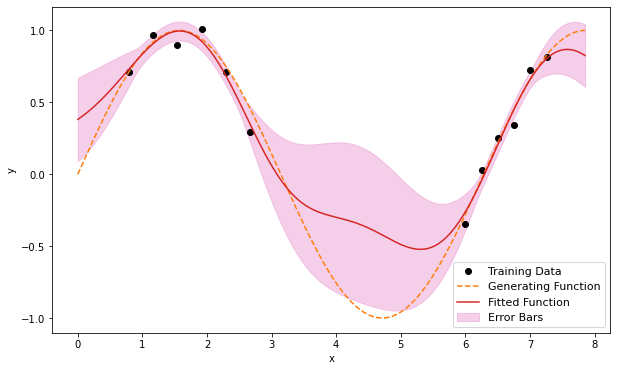

In [10]:
#### **** YOUR CODE HERE **** ####
best_marglike_index = neglog_evidence.index(min(neglog_evidence))
best_lambd = lambdas[best_marglike_index]
best_alpha = best_lambd/s2

Mu, SIGMA = compute_posterior(PHI_train, y_train, best_alpha, s2)
y_post = np.dot(PHI_test, Mu)

plot_regression(y_post, x_train, y_train, x_test, y_test)

var_matrix = np.dot(PHI_test, np.dot(SIGMA , np.transpose(PHI_test)))
var_matrix = np.expand_dims(var_matrix.max(axis=1), axis=1)

upper_bound = y_post + np.sqrt(var_matrix)
lower_bound = y_post - np.sqrt(var_matrix)

plt.fill_between(np.squeeze(x_test), np.squeeze(upper_bound), np.squeeze(lower_bound), alpha=0.35, color='tab:pink', label='Error Bars')
plt.legend(loc='lower right',  prop={'size': 11})
plt.show()

# Check whether your variables are defined as the requirement  ..
try:
    var_matrix
    upper_bound
    lower_bound
except Exception as err:
    print('Error during calculating error bars:', err)

# Task 3b 
**(1 bonus mark)**

This is a more open-ended question, with an opportunity to think more creatively. (Note that there are only two marks available though.)

Imagine you had built the above model for inclusion within some real-world system where it was desired to make predictions at some arbitrary points $x$ in the future. How might the information from your model's predictive variance be useful in the practical application?

Remember that the predictive model is an $x$-dependent Gaussian distribution over the prediction, and in principle the variance quantifies the likely error (which is a consequence both of the noise on the data and any model uncertainty).

More specifically, your answer might look to address the following questions:

- how could the system exploit the predictive variance to practical advantage on new data?
- what evidence can you supply now (based on the existing test data set) to suggest the approach might work?

Explain what you might do in the text box below (no more than 200 words is suggested), and in the following box, generate whatever graph(s) you would offer as supporting evidence for the utility of your approach.


## Using the predictive variance in practice

**Add your explanation here.**



In [11]:
#### **** YOUR CODE HERE **** ####
